In [ ]:
!pip install ray
!pip install -U hyperopt
!pip install vit_pytorch

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch

import os
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from functools import partial

import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF

from vit_pytorch import ViT


#**PREPROCESSING & HELPER FUNCTIONS**

In [ ]:
# FIXED HYPERPARAMETERS
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 60
PATCH_SIZE = 15
NUM_CLASSES = 3
NUM_CHANNELS = 3

RAY_EPOCHS = 20

In [ ]:
CUDA_VISIBLE_DEVICES = 0
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla K80


In [ ]:
def preprocess(path):
    dataset = datasets.ImageFolder(path,
              transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]))

    return dataset

In [ ]:
def data_loader(dataset):
    loader = torch.utils.data.DataLoader(
             dataset,
             batch_size = BATCH_SIZE,
             num_workers = 2)

    return loader

In [ ]:
def plot_image(path):
  img = Image.open(path)
  print("Image Shape:", np.array(img).shape)
  plt.imshow(img)
  plt.axis('off')

#**HYPERPARAMETER OPTIMIZATION**

In [ ]:
def fit(config):

    # Defining model
    model = ViT(dim = config["dim"],
                image_size = 60,
                patch_size = 15,
                depth = config["depth"],
                heads = config["heads"],
                mlp_dim = config["mlp_dim"],
                num_classes = 3,
                channels = 3)
    
    # utilizing gpu
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Preparing the dataset
    train_dataset = preprocess('/content/drive/MyDrive/mask_classifier/split_data/train')
    val_dataset = preprocess('/content/drive/MyDrive/mask_classifier/split_data/val')
    train_loader = data_loader(train_dataset)
    val_loader = data_loader(val_dataset)

    # defining loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    train_losses = np.zeros(20)
    val_losses = np.zeros(20)

    # Start Training
    for e in range(RAY_EPOCHS):
        train_loss = []
        validation_loss = []
        val_steps = 0

        t0 = datetime.now()

        # on the train dataset
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item())  
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        train_losses[e] = train_loss

        # on the val dataset
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item()) 
            val_steps += 1 

        validation_loss = np.mean(validation_loss)
        val_losses[e] = validation_loss

        # Recording the loss value
        tune.report(loss = (validation_loss / val_steps))

        dt = datetime.now() - t0

        print(f"Epoch : {e+1}/{RAY_EPOCHS} => \t Train Loss:{train_loss:.3f} \t Val Loss:{validation_loss:.3f} \t Duration:{dt}")


In [ ]:
config = {
    "dim": tune.choice([64, 128, 256, 512, 1024]),
    "mlp_dim": tune.choice([64, 128, 256, 512, 1024]),
    "depth": tune.choice([3, 4, 5, 6, 7, 8]),
    "heads": tune.choice([6, 7, 8, 9, 10])
}

# scheduler = ASHAScheduler(
#         metric="loss",
#         mode="min",
#         max_t=10,
#         grace_period=1,
#         reduction_factor=2)

hyperopt = HyperOptSearch(metric="loss", mode="min")

reporter = CLIReporter(
    metric_columns=["loss"])

result = tune.run(
    partial(fit),
    config=config,
    # scheduler=scheduler,
    search_alg=hyperopt,
    progress_reporter=reporter,
    fail_fast="raise",
    num_samples = 10,
    resources_per_trial={"cpu": 2, "gpu": 1})

2021-12-09 07:54:02,595	WARNING experiment.py:256 -- No name detected on trainable. Using DEFAULT.
2021-12-09 07:54:02,596	INFO registry.py:70 -- Detected unknown callable for trainable. Converting to class.
2021-12-09 07:54:02,626	WARNING callback.py:115 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
/usr/local/lib/python3.7/dist-packages/ray/tune/trial_runner.py:309: UserWarning: fail_fast='raise' detected. Be careful when using this mode as resources (such as Ray processes, file descriptors, and temporary files) may not be cleaned up properly. To use a safer mode, use fail_fast=True.
  "fail_fast='raise' detected. Be careful when using this "


== Status ==
Current time: 2021-12-09 07:54:02 (running for 00:00:00.12)
Memory usage on this node: 1.9/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 0/2 CPUs, 0/1 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects (0.0/1.0 accelerator_type:K80)
Result logdir: /root/ray_results/DEFAULT_2021-12-09_07-54-02
Number of trials: 1/10 (1 PENDING)
+------------------+----------+-------+---------+-------+---------+-----------+
| Trial name       | status   | loc   |   depth |   dim |   heads |   mlp_dim |
|------------------+----------+-------+---------+-------+---------+-----------|
| DEFAULT_2cdffccc | PENDING  |       |       4 |   128 |      10 |       512 |
+------------------+----------+-------+---------+-------+---------+-----------+


== Status ==
Current time: 2021-12-09 07:54:07 (running for 00:00:05.22)
Memory usage on this node: 3.1/12.7 GiB
Using FIFO scheduling algorithm.
Resources requested: 2.0/2 CPUs, 1.0/1 GPUs, 0.0/7.03 GiB heap, 0.0/3.52 GiB objects (0.0/1.0 acce

2021-12-09 07:59:34,683	INFO tune.py:626 -- Total run time: 332.09 seconds (331.93 seconds for the tuning loop).


Result for DEFAULT_cd17920e:
  date: 2021-12-09_07-59-34
  done: false
  experiment_id: 723093ae2ca34e0b833a7cff7174660a
  hostname: 0658f398b9f8
  iterations_since_restore: 1
  loss: 0.22645175105782983
  node_ip: 172.28.0.2
  pid: 6232
  time_since_restore: 29.35172748565674
  time_this_iter_s: 29.35172748565674
  time_total_s: 29.35172748565674
  timestamp: 1639036774
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: cd17920e
  
Result for DEFAULT_cd17920e:
  date: 2021-12-09_07-59-34
  done: true
  experiment_id: 723093ae2ca34e0b833a7cff7174660a
  experiment_tag: 10_depth=6,dim=512,heads=10,mlp_dim=256
  hostname: 0658f398b9f8
  iterations_since_restore: 1
  loss: 0.22645175105782983
  node_ip: 172.28.0.2
  pid: 6232
  time_since_restore: 29.35172748565674
  time_this_iter_s: 29.35172748565674
  time_total_s: 29.35172748565674
  timestamp: 1639036774
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: cd17920e
  
== Status ==
Current time: 2021-12-09 07:

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result["loss"]}")


best_trained_model = ViT(image_size = 60, patch_size = 15, num_classes = 3, channels = 3,
                         dim = best_trial.config["dim"], mlp_dim = best_trial.config["mlp_dim"], 
                         depth = best_trial.config["depth"], heads = best_trial.config["heads"])

Best trial config: {'dim': 64, 'mlp_dim': 128, 'depth': 6, 'heads': 10}
Best trial final validation loss: 0.06330023590492978


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_trained_model.to(device)

In [ ]:
torch.save(best_trained_model, f"/content/drive/MyDrive/Vision_Transformers/best_model/mask_classifier.pt")

#**TRAINING**

In [ ]:
def batch_gd(model, train_loader, val_loader, epochs):
    train_losses = np.zeros(epochs)
    validation_losses = np.zeros(epochs)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    for e in range(epochs):
        t0 = datetime.now()

        train_loss, validation_loss = [], []

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, targets)
            train_loss.append(loss.item()) 
            loss.backward()
            optimizer.step()

        train_loss = np.mean(train_loss)
        train_losses[e] = train_loss


        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            validation_loss.append(loss.item())  

        validation_loss = np.mean(validation_loss)
        validation_losses[e] = validation_loss

        dt = datetime.now() - t0
        print(f"Epoch : {e+1}/{epochs} => \t Train Loss:{train_loss:.3f} \t Val Loss:{validation_loss:.3f} \t Duration:{dt}")

    return train_losses, validation_losses

In [ ]:
train_dataset = preprocess('/content/drive/MyDrive/mask_classifier/split_data/train')
val_dataset = preprocess('/content/drive/MyDrive/mask_classifier/split_data/val')
# test_dataset = preprocess('/content/drive/MyDrive/mask_classifier/split_data/test')

In [ ]:
train_loader = data_loader(train_dataset)
val_loader = data_loader(val_dataset)
# test_loader = data_loader(test_dataset)

In [ ]:
train_losses, validation_loss = batch_gd(best_trained_model, train_loader, val_loader, EPOCHS)

Epoch : 1/25 => 	 Train Loss:0.193 	 Val Loss:6.155 	 Duration:0:00:30.081106
Epoch : 2/25 => 	 Train Loss:0.643 	 Val Loss:5.757 	 Duration:0:00:27.456762
Epoch : 3/25 => 	 Train Loss:0.260 	 Val Loss:4.374 	 Duration:0:00:27.180636
Epoch : 4/25 => 	 Train Loss:0.411 	 Val Loss:5.535 	 Duration:0:00:27.660505
Epoch : 5/25 => 	 Train Loss:0.547 	 Val Loss:4.193 	 Duration:0:00:27.663107
Epoch : 6/25 => 	 Train Loss:0.394 	 Val Loss:4.179 	 Duration:0:00:27.508642
Epoch : 7/25 => 	 Train Loss:0.627 	 Val Loss:3.215 	 Duration:0:00:27.272161
Epoch : 8/25 => 	 Train Loss:0.761 	 Val Loss:2.748 	 Duration:0:00:27.421220
Epoch : 9/25 => 	 Train Loss:0.819 	 Val Loss:2.397 	 Duration:0:00:27.284707
Epoch : 10/25 => 	 Train Loss:0.880 	 Val Loss:1.888 	 Duration:0:00:27.204265
Epoch : 11/25 => 	 Train Loss:0.855 	 Val Loss:2.025 	 Duration:0:00:27.380645
Epoch : 12/25 => 	 Train Loss:0.850 	 Val Loss:2.112 	 Duration:0:00:27.137217
Epoch : 13/25 => 	 Train Loss:0.870 	 Val Loss:1.974 	 Durati

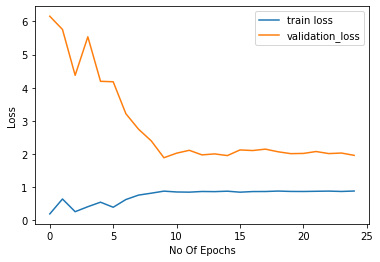

In [ ]:
plt.plot(train_losses, label="train loss")
plt.plot(validation_loss, label="validation_loss")
plt.xlabel("No Of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
def accuracy(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
      inputs, targets = inputs.to(device), targets.to(device)
      # print("targets: ", targets)

      outputs = model(inputs)
      # print("Outputs: ", outputs)

      _, predictions = torch.max(outputs,1)
      # print("Predictions: ", predictions)

      n_correct += (predictions == targets).sum().item()
      n_total += targets.shape[0]

  acc = n_correct / n_total
  # print(n_correct, n_total)

  return str(round(acc, 4) * 100) + "%"

In [ ]:
train_acc = accuracy(best_trained_model, train_loader)
val_acc = accuracy(best_trained_model, val_loader)
# test_acc = accuracy(test_loader)

print("Train Accuracy:", train_acc)
print("Val Accuracy:", val_acc)
# print("Test Accuracy:", test_acc)

Train Accuracy: 24.72%
Val Accuracy: 27.22%


#**INFERENCING**

In [ ]:
train_loader.dataset.classes

['dont_know', 'with_mask', 'without_mask']

In [ ]:
index_to_class = {0: "dont_know", 1: "with_mask", 2: "without_mask"}

In [ ]:
train_dataset.class_to_idx
val_dataset.class_to_idx

{'dont_know': 0, 'with_mask': 1, 'without_mask': 2}

In [ ]:
def single_prediction(model, path):
  image = Image.open(path)
  image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
  input_data = TF.to_tensor(image).to(device)
  input_data = input_data.view((-1, 3, IMAGE_SIZE, IMAGE_SIZE))
  output = model(input_data)
  output = output.cpu().detach().numpy()
  index = np.argmax(output)

  return index_to_class[index]

Image Shape: (129, 75, 3)


(-0.5, 74.5, 128.5, -0.5)

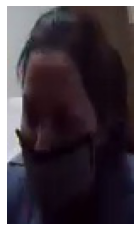

In [ ]:
plot_image("/content/drive/MyDrive/mask_classifier/split_data/test/with_mask/101+pune_drills_201_2021-03-16_17-54-48_016000135.jpg")
plt.axis('off')

In [ ]:
single_prediction(best_trained_model, "/content/drive/MyDrive/mask_classifier/split_data/test/with_mask/101+pune_drills_201_2021-03-16_17-54-48_016000135.jpg")

'without_mask'

In [ ]:
t_time = []
for i in range(100):
  t1 = time.perf_counter()
  single_prediction(best_trained_model, "/content/drive/MyDrive/mask_classifier/split_data/test/with_mask/101+pune_drills_201_2021-03-16_17-54-48_016000135.jpg")
  t2 = time.perf_counter()
  t_time.append(t2 - t1)

avg = sum(t_time) / 100
print(f"Time taken on average for inferencing is: {round(avg * 1000, 2)} ms")

Time taken on average for inferencing is: 12.88ms


In [ ]:
img_path = "/content/drive/MyDrive/mask_classifier/split_data/test/with_mask/101+pune_drills_201_2021-03-16_17-54-48_016000135.jpg"

with torch.autograd.profiler.profile(use_cuda=False) as prof:
    out = single_prediction(best_trained_model, img_path)

print("Inferencing time on CPU: {:.2f} ms".format(prof1.self_cpu_time_total / 1000))

 
# with torch.autograd.profiler.profile(use_cuda=True) as prof:
#     out = single_prediction(best_trained_model, img_path)

# print("Inferencing time on GPU: {:.2f} ms".format(prof2.self_gpu_time_total / 1000))